<a href="https://colab.research.google.com/github/et-tran50/CASE/blob/main/LogisticRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import shap
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve
from sklearn.metrics import precision_recall_fscore_support
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
from sklearn.feature_selection import mutual_info_classif

# Data Loading and Processing

In [3]:
train_data = pd.read_csv('/content/Training Dataset A_R-384922_Candidate Attach #1_PresSE_SRF #1141.csv')
eval_data = pd.read_csv('/content/Evaluation Dataset B_R-384922_Candidate Attach #2_PresSE_SRF #1141.csv')

In [4]:
y = train_data['aprv_flag']  # Target variable
X = train_data.drop(columns=['aprv_flag'])  # Features only

categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(exclude=['object']).columns

X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
encoded_column_names = X_encoded.columns  # Save column names for alignment

In [5]:
mice_imputer = IterativeImputer(max_iter=10, random_state=0)
X_imputed = pd.DataFrame(mice_imputer.fit_transform(X_encoded), columns=encoded_column_names)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=encoded_column_names)


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [6]:
print(y.value_counts())

aprv_flag
1    15952
0     5654
Name: count, dtype: int64


We oversample the under-represented classes

In [7]:
# Oversample the minority class (class 0 is the minority)
X_majority = X_scaled[np.array(y == 1)]
X_minority = X_scaled[np.array(y == 0)]

In [8]:
desired_ratio = 1 / 2
target_minority_size = int(desired_ratio * X_majority.shape[0])

X_minority_oversampled = resample(
    X_minority,
    replace=True,
    n_samples=target_minority_size,
    random_state=42
)

X_oversampled = pd.DataFrame(
    np.vstack((X_majority, X_minority_oversampled)),
    columns=encoded_column_names
)
y_oversampled = np.hstack((
    np.ones(X_majority.shape[0]),
    np.zeros(target_minority_size)
))

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X_oversampled, y_oversampled, test_size=0.2, random_state=42
)

# Exploratory Data Analysis

In [11]:
print(X.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21606 entries, 0 to 21605
Data columns (total 42 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   fico                              21431 non-null  float64
 1   amtfinanced_1req                  21606 non-null  float64
 2   collateral_dlrinput_newused_1req  21606 non-null  object 
 3   pti_1req                          21603 non-null  float64
 4   ltv_1req                          21601 non-null  float64
 5   p12_reh7120_a                     19694 non-null  float64
 6   p12_bcx7110_a                     17917 non-null  float64
 7   p12_all7170_a                     20943 non-null  float64
 8   p12_aut7110_a                     11070 non-null  float64
 9   p12_all7120_a                     21226 non-null  float64
 10  p12_all7937_a                     21522 non-null  float64
 11  p12_bcc8120_a                     19752 non-null  float64
 12  p12_

In [12]:
# Check class balance
y_oversampled_series = pd.Series(y_oversampled)
print(y_oversampled_series.value_counts())

1.0    15952
0.0     7976
Name: count, dtype: int64


In [13]:
# Mean, median, standard deviation, min, max.
print(X.describe())

               fico  amtfinanced_1req      pti_1req      ltv_1req  \
count  21431.000000      21606.000000  21603.000000  21601.000000   
mean     703.643087      29870.867118      9.025000    101.188938   
std       82.786470      15311.300550      4.803567     23.245966   
min      372.000000          0.000000      0.080000     10.350000   
25%      644.000000      19370.000000      5.930000     90.520000   
50%      701.000000      26806.000000      8.590000    103.470000   
75%      766.000000      36931.250000     11.580000    113.800000   
max      894.000000     189729.000000    207.090000    955.260000   

       p12_reh7120_a  p12_bcx7110_a  p12_all7170_a  p12_aut7110_a  \
count   19694.000000   17917.000000   20943.000000   11070.000000   
mean       51.866406      35.863370       3.597288      66.256459   
std        37.352331      33.225946      14.888786      24.470168   
min         0.000000       0.000000       0.000000       0.000000   
25%        16.000000       6.0000

In [14]:
gender_counts = X['Gender'].value_counts()
print("Counts for each gender:")
print(gender_counts)

Counts for each gender:
Gender
Male         11510
Female        8983
Undefined     1113
Name: count, dtype: int64


In [15]:
gender_counts = X['Race'].value_counts()
print("Counts for each race:")
print(gender_counts)

Counts for each race:
Race
White       11806
Hispanic     4864
Black        2941
Other        1441
Asian         554
Name: count, dtype: int64


In [16]:
# Percentage of missing data for each column.
print(X.isnull().sum() / len(X) * 100)

fico                                 0.809960
amtfinanced_1req                     0.000000
collateral_dlrinput_newused_1req     0.000000
pti_1req                             0.013885
ltv_1req                             0.023142
p12_reh7120_a                        8.849394
p12_bcx7110_a                       17.073961
p12_all7170_a                        3.068592
p12_aut7110_a                       48.764232
p12_all7120_a                        1.758771
p12_all7937_a                        0.388781
p12_bcc8120_a                        8.580950
p12_iln7410_a                       10.376747
p12_rev1300_a                        3.684162
p12_all8150_a                       57.386837
p12_bca8370_a                        7.335925
p12_all7517_a                        1.592150
p12_iln8220_a                        8.932704
p12_all6250_a                        0.000000
p12_aua8151_a                       82.449320
p12_rtr7110_a                       42.927890
p12_pil8120_a                     

In [40]:
# Compute the correlation matrix
corr_matrix = X_encoded.corr()

corr_pairs = corr_matrix.unstack().reset_index()
corr_pairs.columns = ['Variable 1', 'Variable 2', 'Correlation']

# Remove self-correlations and duplicate pairs
corr_pairs = corr_pairs[corr_pairs['Variable 1'] != corr_pairs['Variable 2']]
corr_pairs['Abs Correlation'] = corr_pairs['Correlation'].abs()
corr_pairs = corr_pairs.drop_duplicates(subset=['Abs Correlation'])

# Sort by absolute correlation
top_corr = corr_pairs.sort_values(by='Correlation', ascending=False)
top_abs_corr = corr_pairs.sort_values(by='Abs Correlation', ascending=False)

# Display the top correlations
print("Top Correlated Variable Pairs:")
print(top_corr.head(17))
print("\nTop Absoulte Correlated Variable Pairs:")
print(top_abs_corr.head(24))



Top Correlated Variable Pairs:
         Variable 1     Variable 2  Correlation  Abs Correlation
1458    clntr9437_a    clact9429_a     0.945081         0.945081
1600    clall2434_a    cltra4405_a     0.893696         0.893696
436   p12_all7937_a  p12_all7938_a     0.889163         0.889163
578   p12_rev1300_a  p12_als1300_a     0.848632         0.848632
189   p12_reh7120_a  p12_bcx7110_a     0.808004         0.808004
668   p12_bca8370_a  p12_all8370_a     0.754088         0.754088
616   p12_all8150_a  p12_aua8151_a     0.719021         0.719021
1509    clact9429_a    clact9428_a     0.715504         0.715504
1463    clntr9437_a    clact9428_a     0.691852         0.691852
22             fico  p12_all7938_a     0.667274         0.667274
474   p12_bcc8120_a  p12_bca8370_a     0.656980         0.656980
9              fico  p12_all7937_a     0.636410         0.636410
761   p12_iln8220_a  p12_aua8220_a     0.635503         0.635503
992   p12_aua0300_a  p12_als1300_a     0.609645         0.6

In [49]:
# Mutual Information
mutual_info = mutual_info_classif(X_imputed, y)
feature_importance = pd.Series(mutual_info, index=X_imputed.columns)
top_features = feature_importance.sort_values(ascending=False).head(10)
print(top_features)

fico             0.135115
p12_all7937_a    0.086277
p12_all7938_a    0.074465
clntr9437_a      0.073181
clact9428_a      0.070652
clact9429_a      0.068739
p12_bcc3456_a    0.061297
p12_bca8370_a    0.055491
p12_all6971_a    0.047821
p12_bcx7110_a    0.044944
dtype: float64


# Logistic Regression
We employ a logistic regression model using $L_1$ regularization to penalize the coefficients. Further cross validation is done to help prevent overfitting.

In [50]:
# Test different values of C for L1 regularization
best_C = None
best_score = 0
results = {}

print("Tuning Regularization Parameter C...")
for C in [0.01, 0.1, 1.0, 10.0]:
    # Define L1-regularized logistic regression model
    model = LogisticRegression(penalty='l1', solver='liblinear', C=C, random_state=42)

    # Perform cross-validation to evaluate AUROC
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    mean_score = scores.mean()
    results[C] = mean_score

    print(f"C: {C}, Cross-validated AUROC: {mean_score:.4f} ± {scores.std():.4f}")

    # Track the best C based on mean AUROC
    if mean_score > best_score:
        best_C = C
        best_score = mean_score

print(f"\nBest C: {best_C}, Best Cross-validated AUROC: {best_score:.4f}")

# Train the best model
final_model = LogisticRegression(penalty='l1', solver='liblinear', C=best_C, random_state=42)
final_model.fit(X_train, y_train)

Tuning Regularization Parameter C...
C: 0.01, Cross-validated AUROC: 0.8469 ± 0.0035
C: 0.1, Cross-validated AUROC: 0.8489 ± 0.0038
C: 1.0, Cross-validated AUROC: 0.8486 ± 0.0040
C: 10.0, Cross-validated AUROC: 0.8485 ± 0.0040

Best C: 0.1, Best Cross-validated AUROC: 0.8489


LogisticRegression(C=0.1, penalty='l1', random_state=42, solver='liblinear')

# Accuracy Report

In [51]:
# Predict on the test set
y_pred = final_model.predict(X_test)
y_pred_proba = final_model.predict_proba(X_test)[:, 1]

# Evaluate the final model
validation_accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Validation Accuracy: {validation_accuracy:.4f}")
print(f"Validation AUROC: {roc_auc:.4f}")

Validation Accuracy: 0.8015
Validation AUROC: 0.8550


In [52]:
print(classification_report(y_test, final_model.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.74      0.62      0.68      1605
         1.0       0.82      0.89      0.86      3181

    accuracy                           0.80      4786
   macro avg       0.78      0.76      0.77      4786
weighted avg       0.80      0.80      0.80      4786



Logistic Regression uses a 0.5 threshold by default. We can adjust this threshold depending on business needs. In this case, we choose a threshold were recall and precision are balanced.

Intersection Threshold: 0.5697
Precision: 0.8463, Recall: 0.8463


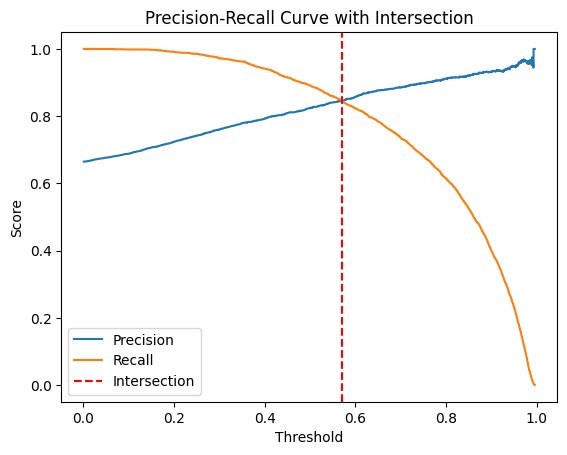

In [53]:
# Calculate precision, recall, and thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Find the intersection point where precision equals recall
differences = np.abs(precisions[:-1] - recalls[:-1])  # Exclude the last threshold
intersection_index = np.argmin(differences)  # Index of the closest point
intersection_threshold = thresholds[intersection_index]

# Intersection point
print(f"Intersection Threshold: {intersection_threshold:.4f}")
print(f"Precision: {precisions[intersection_index]:.4f}, Recall: {recalls[intersection_index]:.4f}")

# Plot the curves
plt.plot(thresholds, precisions[:-1], label="Precision")
plt.plot(thresholds, recalls[:-1], label="Recall")
plt.axvline(x=intersection_threshold, color="red", linestyle="--", label="Intersection")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.title("Precision-Recall Curve with Intersection")
plt.show()


In [54]:
threshold = intersection_threshold
y_pred = (y_pred_proba >= threshold).astype(int)
print(classification_report(y_test, y_pred))

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

              precision    recall  f1-score   support

         0.0       0.70      0.70      0.70      1605
         1.0       0.85      0.85      0.85      3181

    accuracy                           0.80      4786
   macro avg       0.77      0.77      0.77      4786
weighted avg       0.80      0.80      0.80      4786

Precision: 0.85
Recall: 0.85
F1-Score: 0.85


# Evaluation

In [55]:
y_eval = eval_data['aprv_flag']  # Target variable
X_eval = eval_data.drop(columns=['aprv_flag'])  # Drop target column

# Apply the same preprocessing pipeline to evaluation data
X_eval_encoded = pd.get_dummies(X_eval, columns=categorical_cols, drop_first=True)
X_eval_encoded = X_eval_encoded.reindex(columns=X_encoded.columns, fill_value=0)
X_eval_imputed = mice_imputer.transform(X_eval_encoded)
X_eval_scaled = scaler.transform(X_eval_imputed)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [56]:
y_eval_proba = final_model.predict_proba(X_eval_scaled)[:, 1]

# Apply the custom threshold to generate binary predictions
custom_threshold = intersection_threshold
y_eval_pred_custom = (y_eval_proba >= custom_threshold).astype(int)

# Calculate accuracy with the custom threshold
eval_accuracy_custom = accuracy_score(y_eval, y_eval_pred_custom)
print(f"Evaluation Accuracy with Custom Threshold: {eval_accuracy_custom:.4f}")
eval_auroc = roc_auc_score(y_eval, y_eval_proba)
print(f"Evaluation AUROC: {eval_auroc:.4f}")

Evaluation Accuracy with Custom Threshold: 0.7909
Evaluation AUROC: 0.8334


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Evaluation on Minority Class

In [57]:
custom_threshold = intersection_threshold
y_eval_pred_custom = (y_eval_proba >= custom_threshold).astype(int)

minority_class = 0
minority_indices = (y_eval == minority_class)
y_eval_minority = y_eval[minority_indices]
y_eval_pred_minority = y_eval_pred_custom[minority_indices]

accuracy_minority = (y_eval_minority == y_eval_pred_minority).mean()
print(f"Accuracy for the Minority Class: {accuracy_minority:.2%}")

Accuracy for the Minority Class: 67.26%


In [58]:
precision_minority = precision_score(y_eval, y_eval_pred_custom, pos_label=minority_class)
recall_minority = recall_score(y_eval, y_eval_pred_custom, pos_label=minority_class)
f1_minority = f1_score(y_eval, y_eval_pred_custom, pos_label=minority_class)

print(f"Precision for Minority Class: {precision_minority:.2%}")
print(f"Recall for Minority Class: {recall_minority:.2%}")
print(f"F1-Score for Minority Class: {f1_minority:.2%}")

Precision for Minority Class: 58.29%
Recall for Minority Class: 67.26%
F1-Score for Minority Class: 62.45%


# Question 1

*   Q: Suppose an applicant is rejected by our model, how would we explain why?

*   A: SHAP values decompose the prediction for an individual into contributions from each feature, helping us explain why the model made a specific decision.




/usr/local/lib/python3.10/dist-packages/shap/explainers/_linear.py:95: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


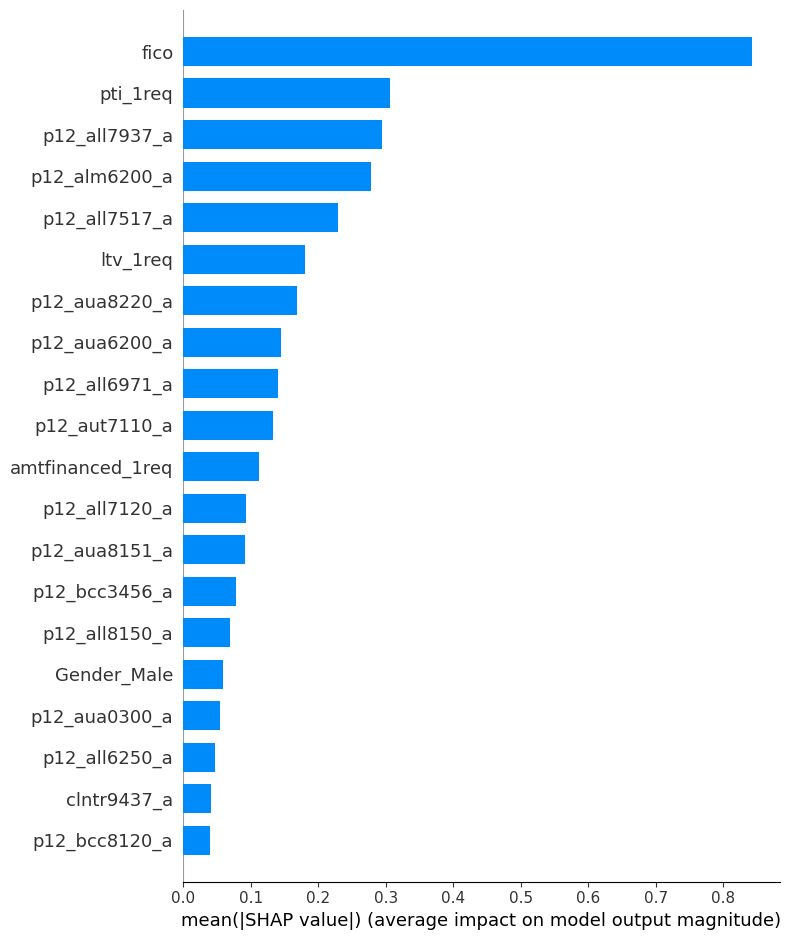

In [59]:
explainer = shap.LinearExplainer(final_model, X_train, feature_perturbation="interventional")

# Calculate SHAP values for the validation set
shap_values = explainer.shap_values(X_test)

#Summary Plot for Feature Importance
shap.summary_plot(shap_values, X_test, feature_names=X_encoded.columns, plot_type="bar")

# Q2


1.   Q: Do female customers have a lower approval rate in our model?
2.   A: In our model, female customers do have a lower approval rate, though the results are not statistically significant.



In [60]:
female_data = train_data[train_data['Gender'] == 'Female']
female_labels = female_data['aprv_flag']
female_features = female_data.drop(columns=['aprv_flag'])
female_features_encoded = pd.get_dummies(female_features, columns=categorical_cols, drop_first=True)

male_data = train_data[train_data['Gender'] == 'Male']
male_labels = male_data['aprv_flag']
male_features = male_data.drop(columns=['aprv_flag'])
male_features_encoded = pd.get_dummies(male_features, columns=categorical_cols, drop_first=True)

overall_features = train_data.drop(columns=['aprv_flag'])
overall_labels = train_data['aprv_flag']
overall_features_encoded = pd.get_dummies(overall_features, columns=categorical_cols, drop_first=True)

In [61]:
def align_columns(data, reference_columns):
    for col in reference_columns:
        if col not in data:
            data[col] = 0
    return data

# Align columns for all datasets
for dataset in [female_features_encoded, male_features_encoded, overall_features_encoded]:
    dataset = align_columns(dataset, encoded_column_names)

In [62]:
female_features_encoded = female_features_encoded[encoded_column_names]
female_features_imputed = mice_imputer.transform(female_features_encoded)
female_features_scaled = scaler.transform(female_features_imputed)

male_features_encoded = male_features_encoded[encoded_column_names]
male_features_imputed = mice_imputer.transform(male_features_encoded)
male_features_scaled = scaler.transform(male_features_imputed)

overall_features_encoded = overall_features_encoded[encoded_column_names]
overall_features_imputed = mice_imputer.transform(overall_features_encoded)
overall_features_scaled = scaler.transform(overall_features_imputed)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [63]:
female_pred_proba = final_model.predict_proba(female_features_scaled)[:, 1]
female_pred = (female_pred_proba >= intersection_threshold).astype(int)

male_pred_proba = final_model.predict_proba(male_features_scaled)[:, 1]
male_pred = (male_pred_proba >= intersection_threshold).astype(int)

overall_pred_proba = final_model.predict_proba(overall_features_scaled)[:, 1]
overall_pred = (overall_pred_proba >= intersection_threshold).astype(int)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [64]:
approval_rate_female = (female_pred == 1).mean()
print(f"Model Approval Rate for Females: {approval_rate_female:.2%}")
approval_rate_male = (male_pred == 1).mean()
print(f"Model Approval Rate for Males: {approval_rate_male:.2%}")
approval_rate_overall = (overall_pred == 1).mean()
print(f"Overall Model Approval Rate: {approval_rate_overall:.2%}")

Model Approval Rate for Females: 68.97%
Model Approval Rate for Males: 70.11%
Overall Model Approval Rate: 70.86%


We choose to perform $Z$-test over chi-squared testing, as it is more geniune to compare female vs male approval rates as our hypothesis, moreso than female vs all, since the original dataset has an undefined entry for gender (could be either).

In [65]:
from statsmodels.stats.proportion import proportions_ztest

# Total approvals for females and males
female_approvals = (female_pred == 1).sum()
male_approvals = (male_pred == 1).sum()

# Total observations for females and males
female_total = len(female_pred)
male_total = len(male_pred)

# Perform the two-proportion Z-test
count = [female_approvals, male_approvals]
nobs = [female_total, male_total]
stat, p_value = proportions_ztest(count, nobs)

# Output results
print(f"Z-Statistic: {stat:.4f}, p-value: {p_value:.4f}")
if p_value < 0.05:
    print("The difference in approval rates is statistically significant.")
else:
    print("The difference in approval rates is not statistically significant.")


Z-Statistic: -1.7579, p-value: 0.0788
The difference in approval rates is not statistically significant.
